## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
import constants
from plot import Plot
from fitting import IterativeSolverMethod
from preprocess_vis import Gridding
from geometry import Geometry

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

In [4]:
def deproject(u, v, inc, pa, inverse=False):  
    inc *= const.deg_to_rad
    pa *= const.deg_to_rad

    cos_t = np.cos(pa)
    sin_t = np.sin(pa)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp

In [5]:
def sweep_profile(r, I, project=False, phase_shift=False, geom=None, axis=0,
                  xmax=None, ymax=None, dr=None, deproject = False ):
    r"""
    Sweep a 1D radial brightness profile over :math:`2 \pi` to yield a 2D
    brightness distribution. Optionally project this sweep by a supplied
    geometry.

    Parameters
    ----------
    r : array
        Radial coordinates at which the 1D brightness profile is defined
    I : array
        Brightness values at r
    project : bool, default = False
        Whether to project the swept profile by the supplied geom
    phase_shift : bool, default = False
        Whether to phase shift the projected profile by the supplied geom.
        If False, the source will be centered in the image
    geom : SourceGeometry object, default=None
        Fitted geometry (see frank.geometry.SourceGeometry). Here we use
        geom.inc [deg], geom.PA [deg], geom.dRA [arcsec], geom.dDec [arcsec] if
        project=True
    axis : int, default = 0
        Axis over which to interpolate the 1D profile
    xmax, ymax : float, optional, default = None
        Value setting the x- and y-bounds of the image (same units as r). The
        positive and negative bounds are both set to this value (modulo sign).
        If not provided, these will be set to r.max()
    dr : float, optional, default = None
        Pixel size (same units as r). If not provided, it will be set at the
        same spatial scale as r

    Returns
    -------
    I2D : array, shape = (len(r), len(r))
        2D brightness distribution (projected if project=True)
    xmax : float
        Maximum x-value of the 2D grid
    ymax : float
        Maximum y-value of the 2D grid

    Notes
    -----
    Sign convention: a negative geom.dRA shifts the source to the right
    in the image

    """
    if project or deproject:
        inc, pa = geom['inc'], geom['pa']
        inc *= constants.deg_to_rad
        pa *= constants.deg_to_rad

        cos_i = np.cos(inc)
        cos_pa, sin_pa = np.cos(pa), np.sin(pa)

    if xmax is None:
        xmax = r.max()
    if ymax is None:
        ymax = r.max()

    if dr is None:
        dr = np.mean(np.diff(r))

    x = np.linspace(-xmax, xmax, int(xmax/dr))
    y = np.linspace(-ymax, ymax, int(ymax/dr))
    print(len(x))

    if phase_shift:
        xi, yi = np.meshgrid(x + geom['dra'], y - geom['ddec'])
    else:
        xi, yi = np.meshgrid(x, y)

    if project:
        xp  = xi * cos_pa + yi * sin_pa
        yp  = -xi * sin_pa + yi * cos_pa
        xp /= cos_i
        r1D = np.hypot(xp, yp)
    elif deproject:
        xp = xi * cos_i
        x_unrot = xp * cos_pa - yi * sin_pa
        y_unrot = xp * sin_pa + yi * cos_pa
        r1D = np.hypot(x_unrot, y_unrot)
    else:
        r1D = np.hypot(xi, yi)

    im_shape = r1D.shape + I.shape[1:]
    print(im_shape)

    interp = interp1d(r, I, bounds_error=False, fill_value=0., axis=axis)
    I2D = interp(r1D.ravel()).reshape(*im_shape)

    return I2D, xmax, ymax

In [6]:
def deproject_profile(r, I, phase_shift=False, geom=None, axis=0, xmax=None, ymax=None, dr=None):
    inc, pa = geom['inc'], geom['pa']
    inc *= constants.deg_to_rad
    pa *= constants.deg_to_rad

    cos_i = np.cos(inc)
    cos_pa, sin_pa = np.cos(pa), np.sin(pa)

    if xmax is None:
        xmax = r.max()
    if ymax is None:
        ymax = r.max()

    if dr is None:
        dr = np.mean(np.diff(r))

    x = np.linspace(-xmax, xmax, int(xmax/dr))
    y = np.linspace(-ymax, ymax, int(ymax/dr))

    if phase_shift:
        xi, yi = np.meshgrid(x + geom['dra'], y - geom['ddec'])
    else:
        xi, yi = np.meshgrid(x, y)

    xp = xi * cos_i
    x_unrot = xp * cos_pa - yi * sin_pa
    y_unrot = xp * sin_pa + yi * cos_pa
    r1D = np.hypot(x_unrot, y_unrot)

    return r1D, I

### Data

In [7]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

In [8]:
N = 300

In [9]:
m, c, l = -0.33, -0.1, 1e5

# Frank2D

In [10]:
geom = Geometry(inc, pa, dra, ddec, deproject = False)
frank2d = Frank2D(N, Rout, geom)

In [11]:
frank2d.preprocess_vis(u, v, Vis, Weights)

/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.03  min |  1.55 seconds
Setting gridded data...


In [12]:
u_gridded, v_gridded, vis_gridded, weights_gridded = frank2d._gridded_data['u'], frank2d._gridded_data['v'], frank2d._gridded_data['vis'], frank2d._gridded_data['weights']


In [13]:
FT = frank2d._FT
x_labels = np.fft.fftshift(FT._u/1e6)
y_labels = np.fft.fftshift(FT._v/1e6)

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_26355/3928879700.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)


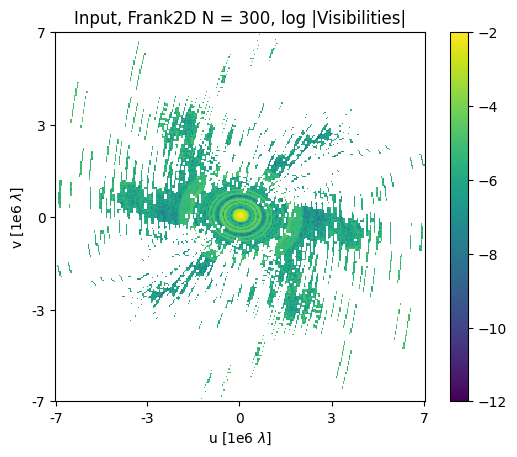

In [14]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Input, Frank2D N = {N}, log |Visibilities|')
plt.colorbar()

In [15]:
frank2d.frank1d(u, v, Vis, Weights)

/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


In [16]:
vis_f1d = frank2d._frank1d_guess

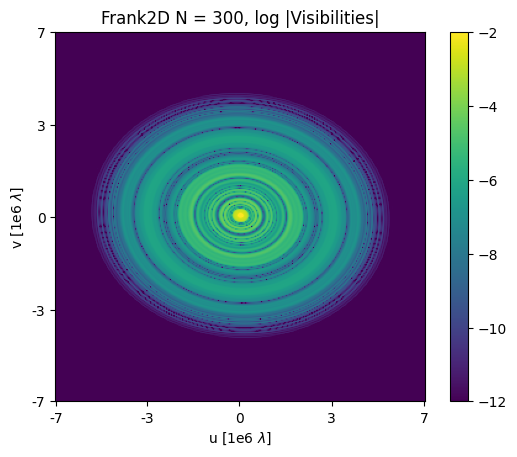

In [17]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_f1d).reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, log |Visibilities|')
plt.colorbar()

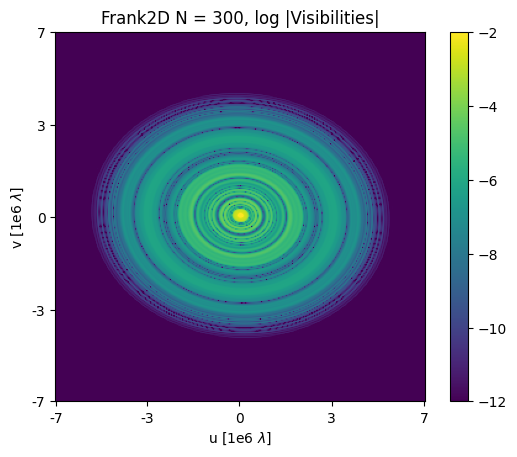

In [18]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_f1d.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, log |Visibilities|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_26355/3226150350.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift((vis_gridded).reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)


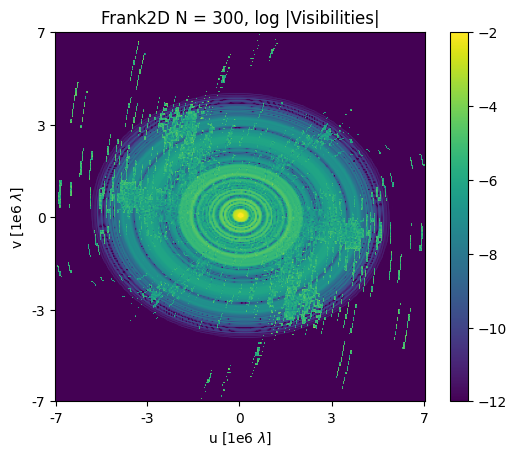

In [19]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_f1d).reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_gridded).reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, log |Visibilities|')
plt.colorbar()

### Running F2D

In [20]:
N = 300

### Deprojected scheme

In [21]:
start_time = time.time()

#####
frank2d_deprojected = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d_deprojected.set_kernel('Wendland', [m, c, l])
frank2d_deprojected.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...
Deprojecting...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.02  min |  0.98 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 4.58  min |  274.57 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 3.6370190753312367e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
  

In [22]:
frank2d_deprojected.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


In [23]:
vis_sol_deprojected = frank2d_deprojected.sol_visibility.reshape(N, N)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_25961/3391530539.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_deprojected))), origin='lower', vmin=-12, vmax=-2)


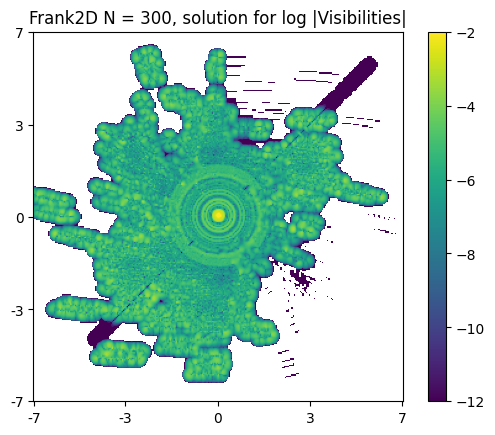

In [24]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_deprojected))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

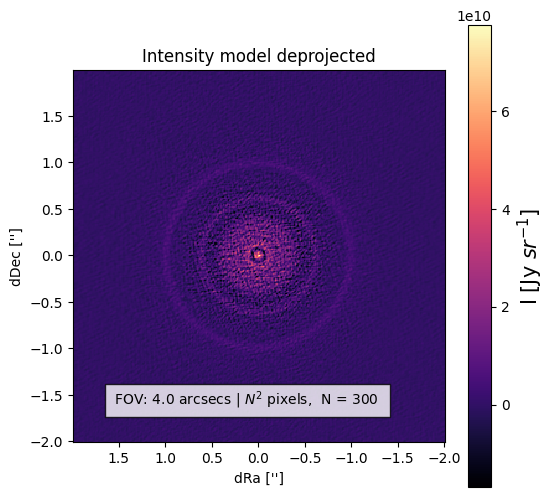

In [25]:
Plot(frank2d_deprojected).get_image("Intensity model deprojected", size = 6)

In [35]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/(N)
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

In [27]:
r_f2d_deprojected, I_f2d_deprojected = get_radial_profile(frank2d_deprojected)

### Projected scheme

In [20]:
start_time = time.time()

#####
Geometry_ = Geometry(inc, pa, dra, ddec, deproject = False)
frank2d = Frank2D(N, Rout, Geometry_)
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:46: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.03  min |  1.70 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 7.19  min |  431.70 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 3.7278393082372274e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
  

In [28]:
vis_sol = frank2d.sol_visibility.reshape(frank2d._FT._Nx, frank2d._FT._Ny)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_26355/2936901632.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol.reshape(N,N)))), origin='lower', vmin=-12, vmax=-2)


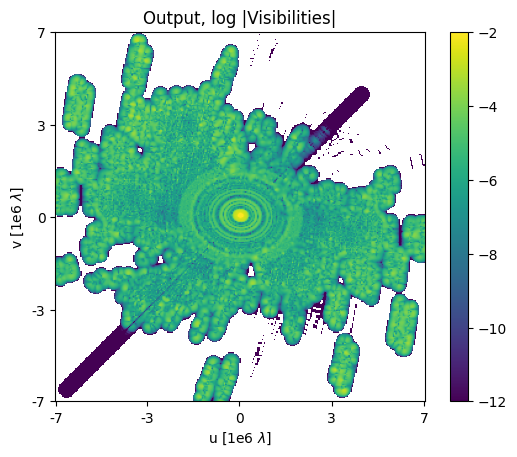

In [29]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol.reshape(N,N)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Output, log |Visibilities|')
plt.colorbar()

In [30]:
frank2d.sol_visibility = frank2d.sol_visibility.reshape(frank2d._FT._Nx, frank2d._FT._Ny)

In [31]:
frank2d.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


In [32]:
class Plot():
    def __init__(self, Frank2D):
        self._frank2d = Frank2D
        
    def get_image(self, title = "Model", size = 7,  add_fourier_resolution = False, log_norm = False):
        frank2d = self._frank2d
        I = frank2d.sol_intensity
        Nx = frank2d._Nx
        Ny = frank2d._Ny
        dx = frank2d._FT._dx*rad_to_arcsec
        dy = frank2d._FT._dy*rad_to_arcsec
        Rout = frank2d._Rmax*rad_to_arcsec
        x = frank2d._FT._x*rad_to_arcsec
        y = frank2d._FT._y*rad_to_arcsec

        # Coordenadas del pixel que quieres mostrar
        pixel_x, pixel_y = Nx//2, Ny//2
        pixel_value = I[pixel_y, pixel_x]

        # Crear una figura con dos subplots
        if add_fourier_resolution:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})
        else:
            fig, ax = plt.subplots(1, 1, figsize=(size, size))
            axs = [ax]
        
        norm = LogNorm() if log_norm else None

        # Primer subplot.
        plot = axs[0].pcolormesh(x, y, I, cmap='magma', norm=norm)
        axs[0].invert_xaxis()
        cmap = plt.colorbar(plot, ax=axs[0], shrink = 0.8)
        cmap.set_label(r'I [Jy $sr^{-1}$]', size=15)

        axs[0].set_title(title)
        axs[0].set_xlabel("dRa ['']")
        axs[0].set_ylabel("dDec ['']")

        xlim = axs[0].get_xlim()
        ylim = axs[0].get_ylim()

        axs[0].text(
            xlim[0] + 0.1 * (xlim[1] - xlim[0]),  # 10% desde el borde izquierdo
            ylim[0] + 0.1 * (ylim[1] - ylim[0]),  # 10% desde el borde inferior
            r' FOV: ' + str(2 * Rout) + ' arcsecs ' + r'| $N^{2}$ pixels,  N = ' + str(Nx) + '  ',
            bbox={'facecolor': 'white', 'pad': 4, 'alpha': 0.8}
        )

        if add_fourier_resolution:
            # Segundo subplot: el pixel específico
            # Creamos una matriz de ceros y luego establecemos el valor del píxel deseado en I[pixel_y, pixel_x]
            pixel_image = np.zeros((1, 1))
            pixel_image[0, 0] = pixel_value
            img = axs[1].imshow(pixel_image, cmap="magma", extent=[0, 1, 0, 1])
            axs[1].set_title(f'Pixel at ({pixel_x}, {pixel_y})')
            axs[1].set_xticks([])
            axs[1].set_yticks([])

            # Colorbar para el pixel específico
            cmap_pixel = plt.colorbar(img, ax=axs[1], shrink=0.5)
            cmap_pixel.set_label(r'I [Jy $sr^{-1}$]', size=9)

            # Configurar notación científica en la barra de color
            cmap_pixel.formatter.set_powerlimits((-2, 2))  # Limitar la notación científica a potencias entre -3 y 3
            cmap_pixel.update_ticks()

            # Mostrar el valor del pixel como leyenda
            axs[1].text(0.5, -0.3, f'Intensity: {pixel_value:.4}', ha='center', va='center', transform=axs[1].transAxes, fontsize=9, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})

            # Agregar indicaciones del largo del pixel en los ejes x y y
            axs[1].annotate('', xy=(0, 0), xytext=(1, 0), arrowprops=dict(arrowstyle='<->', color='black'))
            axs[1].text(0.5, -0.05, f'{dx: .5f} ["]', ha='center', va='top', transform=axs[1].transAxes)

            axs[1].annotate('', xy=(0, 0), xytext=(0, 1), arrowprops=dict(arrowstyle='<->', color='black'))
            axs[1].text(-0.05, 0.5, f'{dy: .5f}  ["]', ha='right', va='center', transform=axs[1].transAxes, rotation='vertical')

            # Ajustar el tamaño de los subplots
            plt.tight_layout()
            plt.subplots_adjust(wspace=0.2)
        
        plt.gca().set_aspect('equal') 

        plt.show()

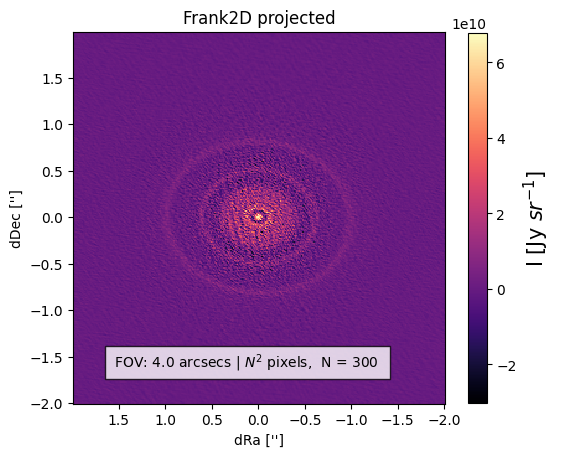

In [48]:
Plot(frank2d).get_image('Frank2D projected', size = 6)

In [36]:
r_f2d, I_f2d = get_radial_profile(frank2d)

### Frank1d

In [37]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-3

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

In [38]:
def radial_profile(x, y, I):
    x, y = np.meshgrid(x, y, indexing='ij')
    r = np.hypot(x, y)
    N_ = I.shape[1]
    r = r.flatten()
    I = I.flatten()
    bin = (np.max(r) - np.min(r))/N_
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return r_centers, I_binned

In [42]:
# We use same dimensions of Frank2D
xmax = frank2d._FT._x.max()*rad_to_arcsec
ymax = frank2d._FT._y.max()*rad_to_arcsec
dr = xmax/N

#### Deprojected profile

In [137]:
I2D_deprojected, xmax_out_deprojected, ymax_out_deprojected = sweep_profile(sol.r, sol.mean, project= False, phase_shift = False, geom = {'inc': inc, 'pa':pa, 'dra':dra, 'ddec':ddec}, xmax = xmax, ymax = ymax, dr = dr)



300
(300, 300)


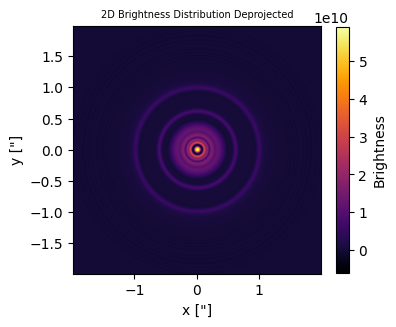

In [138]:
# Crear grilla para el gráfico
x_deprojected = np.linspace(-xmax_out_deprojected, xmax_out_deprojected, I2D_deprojected.shape[1])
y_deprojected = np.linspace(-ymax_out_deprojected, ymax_out_deprojected, I2D_deprojected.shape[0])

# Gráfico con imshow
plt.figure(figsize=(4, 4))
extent = [-xmax_out_deprojected, xmax_out_deprojected, -ymax_out_deprojected, ymax_out_deprojected]  # Extensión del gráfico
plt.imshow(I2D_deprojected, extent=extent, origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Brightness', shrink= 0.8)
plt.xlabel('x ["]')
plt.ylabel('y ["]')
plt.title('2D Brightness Distribution Deprojected', size= 7)
plt.gca().set_aspect('equal') 
plt.show()


#### Projected profile

In [43]:
I2D, xmax_out, ymax_out = sweep_profile(sol.r, sol.mean, project= True, phase_shift = False, geom = {'inc': inc, 'pa':pa, 'dra':dra, 'ddec':ddec}, xmax = xmax, ymax = ymax, dr = dr)

300
(300, 300)


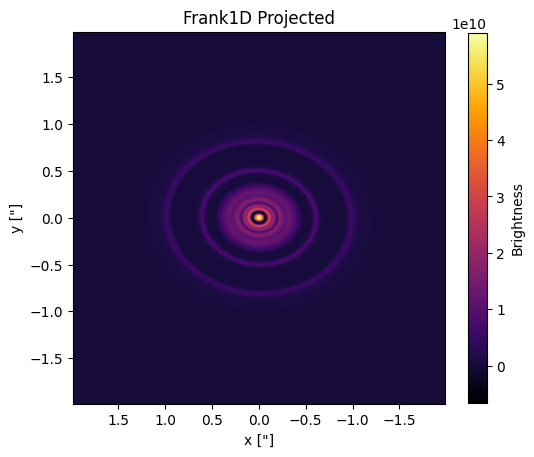

In [57]:
# Crear grilla para el gráfico
x = np.linspace(-xmax_out, xmax_out, I2D.shape[1])
y = np.linspace(-ymax_out, ymax_out, I2D.shape[0])

# Gráfico con imshow
plt.figure(figsize=(6, 6))
extent = [xmax_out, -xmax_out, -ymax_out, ymax_out]  # Extensión del gráfico
plt.imshow(I2D, extent=extent, origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Brightness', shrink= 0.8)
plt.xlabel('x ["]')
plt.ylabel('y ["]')
plt.title('Frank1D Projected', size = 12)
plt.gca().set_aspect('equal') 
plt.show()

In [51]:
r1d, I1d = radial_profile(x, y, I2D)

### Comparison

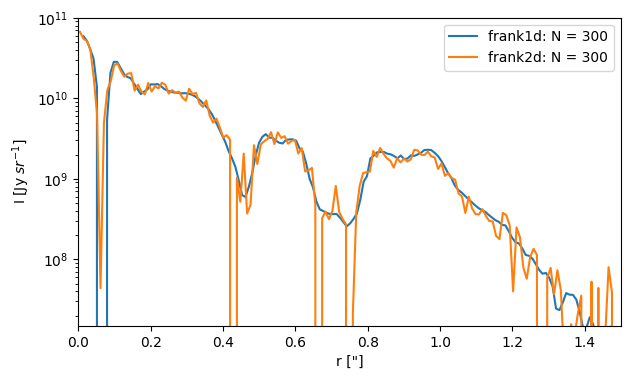

In [52]:
plt.figure(figsize=(7,4))
#plt.plot(sol.r, sol.mean, 'black',label =f'frank1d deprojected: N = {n_pts}')
#plt.plot(r_f2d_deprojected, I_f2d_deprojected, label = f'frank2d deprojected: N = {N}')
plt.plot(r1d, I1d, label = f'frank1d: N = {N}')
plt.plot(r_f2d, I_f2d, label = f'frank2d: N = {N}')
plt.xlabel('r ["]')
plt.xlim(0,1.5)      
plt.ylim(1.5e7, 1e11)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.yscale("log")
plt.show()

In [53]:
frank2d_diff = Frank2D(N, Rout, Geometry(inc, pa, dra, ddec, deproject = True))
frank2d_diff.sol_intensity = I2D - frank2d.sol_intensity

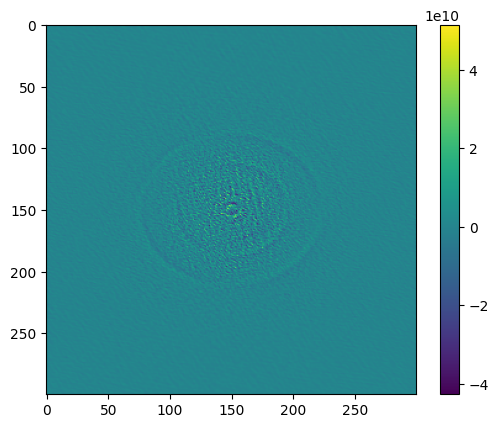

In [55]:
plt.imshow(frank2d_diff.sol_intensity)
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_18027/3429611353.py:32: RuntimeWarning: invalid value encountered in divide
  return q_centers, Vis_Weights_binned/Weights_binned


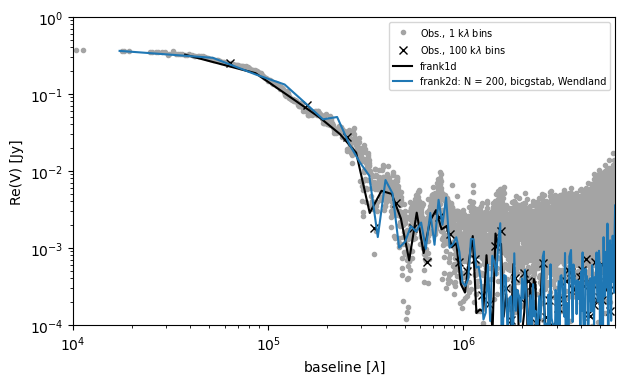

In [27]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [311]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [312]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r, I, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

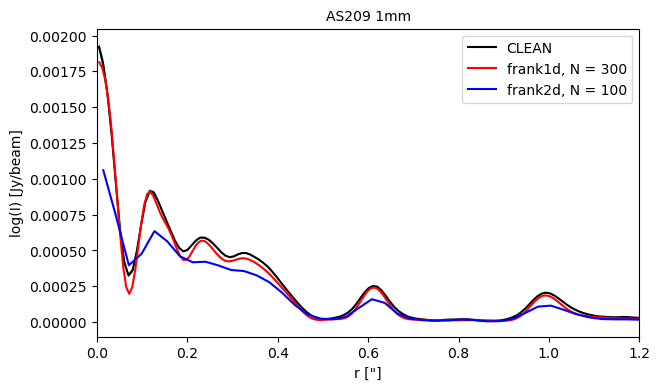

In [313]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()